<h1>Finding Candidate Locations for Starting a French Restaurant in Hong Kong</h1>

Course: Applied Data Science Capstone  
Date of creation: December 23, 2019  
Author: Hyunmyung Myung 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#0)<br>
2. [Data](#1)<br>
3. [Methods](#2) <br>
3.1. [Coordinates](#3) <br>
3.2. [Foursquare API](#4) <br>
3.3. [K-means](#5) <br>
4. [Results](#6) <br>
4.1. [Cluster 0](#7) <br>
4.2. [Cluster 1](#8) <br>
4.3. [Cluster 2](#9) <br>
4.4. [Cluster 3](#10) <br>
4.5. [Cluster 4](#11) <br>
5. [Discussion and Conclusion](#12) <br>
</div>

<h2>1. Introduction</h2><a id="0"></a>

This project assumes the following scenario. A group of stakeholders have consulted to find the best location for opening a new branch of French restaurant. Their initial small bistro in Paris has grown into a Michellin-starred, multinational business that spans across United States, Brazil, Germany, and other countries in the Western hemisphere, and now they want to expand their portfolio by opening up a new branch in the East. Hong Kong was chosen because the city is known for having the largest concentration of high-net-worth individuals of any city in the world[1], and its demographics seemed compatible with the business model of the stakeholders (3 E's they called it: exquisite, enamoring, and expensive). Hong Kong would be a real-world lab where they would experiment to see if the populations of the Eastern cities would be enamored to take the bite of 3 E's.

To find out the optimal location for opening a restaurant branch, three factors were taken into account:

1. **Proportion of French restaurants to all types of restaurants**: this factor indicates the potential demand for French restaurants in a given area -- lower proportion, higher likelihood. Proportion is used here instead of the sheer number of French restaurants, because less numbers may mean that there just are not enough demands due to less foot traffic, lower residential density, etc.


2. **Price points of the French restuanrants in the vicinity**: the business of the stakeholders aims for the best cuisine that money can buy, no moderation on ingredients or human resources whatsoever. This means the effect of a budget French restaurant on the potential demand of the stakeholder's restaurant would be less than a French restaurant with a similar price point.


3. **Ratings of the French restaurants in the vicinity**: nearby French restaurants with lower ratings would have less impact on the profitability of the new branch to be opened by the stakeholders, and vice versa.

<h2>2. Data</h2><a id="1"></a>

- Area names: Wikipedia (https://en.wikipedia.org/wiki/List_of_places_in_Hong_Kong)
- Coordinates: Geocoder (extracted using the above area names)
- Venue information: Foursquare API

<h2>3. Methods</h2><a id="2"></a>

<h3>3.1. Coordinates</h3><a id="3"></a>

The first data to be attained are the coordinates of various areas that fall under the districts of Hong Kong. The most comprehensive, though not complete, of the found data were on a Wikipedia page (https://en.wikipedia.org/wiki/List_of_places_in_Hong_Kong). This list should work out to provide coordinates for locating relevant venues via Foursquare. The following cell imports the page using Beautiful Soup in a Python-readable form.

In [1]:
pd.set_option('display.max_rows', None) #To display all rows of dataframes (personal preference)

import requests
from bs4 import BeautifulSoup

wiki = requests.get('https://en.wikipedia.org/wiki/List_of_places_in_Hong_Kong').text
soup = BeautifulSoup(wiki,'lxml')

#print(soup.prettify())

Next, the below cell lists a custom function that converts the above Beautiful Soup output to a dataframe of area names.

In [121]:
import re
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

def soup_to_df(district,raw_soup): #raw_soup example: filtered_data[4]
    filtered_data = soup.findAll('ul') #"<ul>" used as a separator for separating components of the Soup output

    soup_discrete = str(raw_soup).split('</a>') #"</a>" used as a separator for creating discrete items of area names
    soup_discrete_scrubbed = [] #Empty list to which area names with no unnecessary substrings will be inputted

    for item in soup_discrete:
        edited_item = str(item).replace('\n','') #Remove line breaks from the item

        if ('(' in str(edited_item) and ')' not in str(edited_item)): #Observation revealed this condition indicates the item is not meaningful
            pass
        elif '<ul>' in str(edited_item): #"<ul>" means upping a level of indentation 
            soup_discrete_scrubbed.append(re.sub(r'.+">','<ul>',str(edited_item)))
        elif str(edited_item).count('</ul>') == 1: #"</ul>" means downing a level of indentation 
            soup_discrete_scrubbed.append(re.sub(r'.+">','</ul>',str(edited_item)))
        elif str(edited_item).count('</ul>') == 2: #Double "</ul>" means downing two levels of indentation
            soup_discrete_scrubbed.append(re.sub(r'.+">','</ul></ul>',str(edited_item)))
        else: #No change to the indentation level
            soup_discrete_scrubbed.append(re.sub(r'.+">','',str(edited_item)))        

    df = pd.DataFrame(columns=[n for n in range(7)]) #Create an empty dataframe with required number of columns
    column_level,row_level = 0,0 #Used in the for loop directly below

    for item in soup_discrete_scrubbed: #Maps the list items in a dataframe based on the indentation changes in each item
        if '</li>' not in str(item):
            if '<ul>' in str(item):
                column_level += 1
                item = item.replace('<ul>','')
            elif '</ul>' in str(item):
                column_level -= str(item).count('</ul>')
                row_level += 1
                item = item.replace('</ul>','')
            else:
                row_level += 1

            df.at[row_level,column_level] = str(item)

            try:
                for n in [1,2]: #Extrapolate level 2 and 3 names from cells directly above
                    if np.isnan(df.at[row_level,n]) == True:
                        df.at[row_level,n] = df.at[row_level-1,n]
            except:
                pass

    number_of_rows = df.shape[0] #Used in the next for loop
    geolocator = Nominatim(user_agent="default",timeout=15) #For finding the coordinate of each area 
    
    for n in range(number_of_rows): #This loop generates the address and the coordinate of the areas listed in the soup
        df.at[n,0] = district

        try: #If level 3 is NaN
            if np.isnan(df.at[n,3]) == True: 
                df.at[n,4] = f'{df.at[n,2]}, {df.at[n,1]}, {df.at[n,0]}, Hong Kong'
        except: #If level 3 is not NaN
            df.at[n,4] = f'{df.at[n,3]}, {df.at[n,2]}, {df.at[n,1]}, {df.at[n,0]}, Hong Kong'
        
        address = str(df.at[n,4])
        
        try:
            location = geolocator.geocode(address) #Coordinate extraction using the address
            df.at[n,5] = location
            df.at[n,6] = f'{location.latitude}, {location.longitude}' #Write the coordinate values in the 2nd 
        except:
            df.at[n,5] = np.nan
            df.at[n,6] = np.nan
            
    df.drop([0,1,2,3],axis=1,inplace=True) #Drop columns no longer necessary    
    df.columns = ['Intended Address','Retrieved Address','Coordinate'] #Name the remaining columns
    df.style.set_properties(subset=['Intended Address','Retrieved Address','Coordinate'],**{'width':'250px'}) #Set the width of the columns
    
    return(df) #Return the output

Using the custom function as defined above, the coordinate values of each area will be retrieved using the addresses generated by processing the information in the Wikipedia soup. These coordinates will be used as geological points at which venue information will be searched using Foursquare. Each instance of the custom function is written in a separate cell, because it takes time to retrieve the coordinates.

In [108]:
#Find the index value of the item where Kowloon data resides, then run the custom function with the located soup item
index_hkisland = [index for index, content in enumerate(filtered_data) if 'Kowloon City District' in str(content)]
df_hkisland = soup_to_df('Hong Kong Island',filtered_data[index_hkisland[0]])

In [118]:
#Index of Kowloon data to the custom function
index_kowloon = [index for index, content in enumerate(filtered_data) if 'Kowloon City District' in str(content)]
df_kowloon = soup_to_df('Kowloon and New Kowloon',filtered_data[index_kowloon[0]])

In [123]:
#Index of New Territories data to the custom function
index_newterr = [index for index, content in enumerate(filtered_data) if 'Islands District' in str(content)]
df_newterr = soup_to_df('New Territories',filtered_data[index_newterr[0]])

Let's look at an excerpt of one of the created dataframes to evaluate the results of the custom function.

In [130]:
df_hkisland.head(10)

,Intended Address,Retrieved Address,Coordinate
0,"Admiralty, Central District, Central and Weste...","(香港 Hong Kong, 8, 金融街 Finance Street, 金鐘 Admir...","22.2850394, 114.1583819"
1,"Soho, Mid-Levels, Central and Western District...",NaN,NaN
2,"The Peak, Central and Western District, Hong K...","(山頂 The Peak, 香港 Hong Kong, 中西區 Central and We...","22.2699166, 114.1506667"
3,"Kennedy Town, Sai Wan, Central and Western Dis...",NaN,NaN
4,"Sai Ying Pun, Sai Wan, Central and Western Dis...",NaN,NaN
5,"Shek Tong Tsui, Sai Wan, Central and Western D...","(石塘咀 Shek Tong Tsui, 皇后大道西 Queen's Road West, ...","22.2863321, 114.1336257"
6,"Sheung Wan, Central and Western District, Hong...","(上環 Sheung Wan, 香港 Hong Kong, 中西區 Central and ...","22.2868701, 114.150267"
7,"Fortress Hill, Causeway Bay, Eastern District,...",NaN,NaN
8,"Tin Hau, Causeway Bay, Eastern District, Hong ...","(天后 Tin Hau, 1, 英皇道 King's Road, 加路連山 Caroline...","22.2822499, 114.191786739649"
9,"Heng Fa Chuen, Chai Wan, Eastern District, Hon...","(杏花邨 Heng Fa Chuen, 100, 盛泰道 Shing Tai Road, 樂...","22.27664325, 114.239772961432"


It can be observed above that the geocoder module was unable to retrieve the coordinates for some of the address items. To deal with this limitation, the non-retrieved NaN entries will be removed by dropping associated rows.

In [155]:
#Firstly the dataframes of three regions are combined into one
df_combined = pd.concat([df_hkisland,df_kowloon,df_newterr])

#The NaN values in the "Coordinate" column are dropped
before = df_combined.shape[0]
df_combined.dropna(subset=['Coordinate'],axis=0,inplace=True)
df_combined.reset_index(inplace=True) #Reset the index
df_combined.drop(['index'],axis=1,inplace=True) #Drop the old index column
after = df_combined.shape[0]
print(f'{before - after} rows removed; {after} rows remaining')

82 rows removed; 116 rows remaining


In [183]:
#Save for future use
df_combined.to_csv("df_combined_hongkong.csv",index=True)

The retrieved coordinates are visualized using Folium.

In [184]:
#Determining the coordinate of Hong Kong
geolocator = Nominatim(user_agent="default",timeout=15)
location = geolocator.geocode('Hong Kong')

In [181]:
#Folium map of Hong Kong
import folium
map_hk = folium.Map(location=[location.latitude,location.longitude],zoom_start=10.5,tiles='OpenStreetMap')

#Add markers to the map and display it
for address,coordinate in zip(df_combined['Retrieved Address'],df_combined['Coordinate']):
    latitude,longitude = str(coordinate).split(',')[0],str(coordinate).split(',')[1]
    label = folium.Popup(address,parse_html=True)
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        popup=label,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk)  

map_hk

The map shows that some coordinates are too close to one another to be valuable as separate locations for Foursquare searching. These overlapping coordinates will be united into larger units using DBSCAN to avoid redundant analyses.

In [ ]:
df_cluster_list = []

for address,coordinate in zip(df_combined['Retrieved Address'],df_combined['Coordinate']):
    latitude = float(coordinate.split(',')[0])
    longitude = float(coordinate.split(',')[1])
    df_cluster_list.append([address,latitude,longitude])

df_abridged = []
df_abridged = pd.DataFrame(df_cluster_list,columns=['Address','Latitude','Longitude'])

#Run DBSCAN to reach the target number of clusters
from sklearn.cluster import DBSCAN

df_cluster = df_abridged[['Latitude','Longitude']]
number_of_clusters = 0
result = []
target = 80 #Resulting number of clusters plus that of unclustered locations will attempt to reach this value 80

for a in np.arange(0.00001,0.01,0.00001): #0.01 for 2nd
    for b in np.arange(1,5,1):
        dbscan = DBSCAN(eps=a,min_samples=b).fit(df_cluster.values)
        
        #Record the hyperparameter values that reach the target number of locations
        if (len(set(dbscan.labels_)) > number_of_clusters) and (((len(set(dbscan.labels_))) + list(dbscan.labels_).count(-1)) <= target):
            number_of_locations = (len(set(dbscan.labels_))) + list(dbscan.labels_).count(-1)
            result = [a,b,number_of_locations]

print(f'Optimal hyperparameter values: epsilon = {result[0]}, minimum sample = {result[1]}, number of locations = {result[2]}.')
print(f'Locations clustered to reduce {df_combined.shape[0] - number_of_locations} rows.')

#Train again with the optimal hyperparameter values and attach the labels to df_abridged
dbscan = DBSCAN(eps=result[0],min_samples=result[1]).fit(df_cluster.values)
df_abridged['Cluster Labels'] = dbscan.labels_

Now, the centroid of each cluster will be calculated.

In [383]:
cluster_list = []

for n in range(len(set(dbscan.labels_)) - 1): #Iterating through each cluster (minus one takes account of unassigned or "-1" label)
    df_temp = df_abridged[df_abridged['Cluster Labels'] == n]
    latitude_mean = df_temp['Latitude'].mean()
    longitude_mean = df_temp['Longitude'].mean()
    cluster_list.append([n,latitude_mean,longitude_mean])

In [421]:
df_clustered = df_abridged[['Cluster Labels','Latitude','Longitude']][df_abridged['Cluster Labels'] == -1]
df_clustered = df_clustered.append(pd.DataFrame(cluster_list,columns=['Cluster Labels','Latitude','Longitude']))

#Reset the index
df_clustered.reset_index(inplace=True)
df_clustered.drop(['index'],axis=1,inplace=True)

df_clustered.head(5)

,Cluster Labels,Latitude,Longitude
0,-1,22.285039,114.158382
1,-1,22.269917,114.150667
2,-1,22.286332,114.133626
3,-1,22.286870,114.150267
4,-1,22.276643,114.239773


Now, Folium to show the visual result of DBSCAN:

In [423]:
#Folium map of Hong Kong (clustered)
map_hk_clustered = folium.Map(location=[location.latitude,location.longitude],zoom_start=10.5,tiles='OpenStreetMap')

#Add markers to the map and display it
for latitude,longitude in zip(df_clustered['Latitude'],df_clustered['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_clustered)  

map_hk_clustered

It can be observed in the above map that the collection of coordinates seems less crowded than the pre-cluster version. Now that the number of coordinates has reduced to a manageable level, **Foursquare API** will be employed to determine the viability of opening a French restaurant at each coordinate.

<h3>3.2. Foursquare API</h3><a id="4"></a>

In [573]:
fs_client_id = 'PJUMQQ5B5QKLY0CO4WPTNUBFZ1HSCD2Q3ABBQUNVUGJGXDWJ' #Foursquare ID (free version)
fs_client_secret = '4H0UOPKIRU4AIKEXBWPNXGICM331G4CYRSNO2WDNRFO4JLGP' #Foursquare Secret (free version)
fs_version = '20191225' #Foursquare API version

#To prevent using up precious calls
fs_regular_limit = 1000
fs_premium_limit = 5

The proportion of the number of French restaurants to that of all types of restaurants will be generated here.

In [596]:
fs_result_list = []

for search_latitude,search_longitude in zip(df_clustered['Latitude'],df_clustered['Longitude']):
    search_radius = 1000
    intent = 'browse'
    categoryid_food = '4d4b7105d754a06374d81259' #Food (encompasses French restaurant)
    categoryid_french = '4bf58dd8d48988d10c941735' #French restaurant
    list_temp = []

    #Retrieve the number of restaurants of all types near the given coordinate
    for categoryid in [categoryid_food,categoryid_french]:
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}&categoryId={}'.format(
            fs_client_id, 
            fs_client_secret, 
            fs_version, 
            search_latitude, 
            search_longitude, 
            search_radius, 
            fs_regular_limit,
            intent,
            categoryid)

        fs_result = requests.get(url).json()
        list_temp.append(pd.DataFrame(fs_result['response']).shape[0]) #Store the number of retrieved restaurants in the temporary list
    
    #Record the coordinates and search results into the list ("if" used to avoid division by 0)
    if list_temp[0] != 0:
        fs_result_list.append([search_latitude,search_longitude,list_temp[0],list_temp[1],list_temp[1]/list_temp[0]])
    else:
        fs_result_list.append([search_latitude,search_longitude,list_temp[0],list_temp[1],np.nan])

In [597]:
#Convert the Foursquare result list into a dataframe
df_proportion = pd.DataFrame(fs_result_list,columns=['Latitude','Longitude','Restaurants #','French #','Proportion'])
df_proportion.to_csv("df_proportion_hongkong.csv",index=True) #Save for future

Because harboring no restaurants in an area (especially in a hyper-developed state like Hong Kong) means there is probably no demand for restaurants in that area, the rows that have zero restaurants will be dropped from the dataframe.

In [598]:
df_proportion = df_proportion[df_proportion['Restaurants #'] != 0]
df_proportion.reset_index(inplace=True)
df_proportion.drop(['index'],axis=1,inplace=True)

In [599]:
#To review the resulting dataframe
print(df_proportion.shape)
df_proportion.head()

(71, 5)


,Latitude,Longitude,Restaurants #,French #,Proportion
0,22.285039,114.158382,50,50,1.00
1,22.269917,114.150667,13,0,0.00
2,22.286332,114.133626,50,8,0.16
3,22.286870,114.150267,50,50,1.00
4,22.276643,114.239773,40,0,0.00


As can be seen from the shape of the above dataframe, the number of candidate locations has been reduced to 59. However, it seems that the proportion cannot be used as meaningful data, because the number of venues that can be retrieved by each call is limited to 50. This is why some of the proportion values are 1.00 as can be seen above. To bypass this limitation, the proportion variable will be substituted by the number of French restaurants to approximate the density of the restaurants of this type.

Now, Foursquare's premium calls will be performed to collect additional information on the coordinates, which includes **the average price point of the restaurants** and **the average rating of the French restaurants** (to be collected in this order). The average price of the restaurants is collected using the "explore" function of the Foursquare API. To extract this data just using regular calls, the "price point" parameter of the explore call is used to count of the number of restaurants for each point and then to calculate average price point of each location.

In [600]:
fs_result_list = []
categoryid = '4d4b7105d754a06374d81259' #"Food" category

for search_latitude,search_longitude in zip(df_proportion['Latitude'],df_proportion['Longitude']):
    search_radius = 1000 #Increased to encompass more restaurants   
    venue_sum,venue_count = 0.0,0

    for price_point in range(1,5): #Iterate through the different price points
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&price={}&time=any&day=any&openNow=0&sortByPopularity=1'.format(
                    fs_client_id, 
                    fs_client_secret, 
                    fs_version, 
                    search_latitude, 
                    search_longitude, 
                    search_radius, 
                    fs_regular_limit,
                    categoryid,
                    price_point)

        fs_result = requests.get(url).json()

        venue_sum += price_point * float(len(fs_result['response']['groups'][0]['items']))
        venue_count += int(len(fs_result['response']['groups'][0]['items']))
    
    if venue_count != 0:
        average_price_point = venue_sum / venue_count
    else:
        average_price_point = np.nan
    
    fs_result_list.append([search_latitude,search_longitude,venue_sum,venue_count,average_price_point])

In [601]:
df_price = pd.DataFrame(fs_result_list,columns=['Latitude','Longitude','venue_sum','venue_count','Average price point'])
df_proportion['Average price point'] = df_price['Average price point']
df_proportion.head()

,Latitude,Longitude,Restaurants #,French #,Proportion,Average price point
0,22.285039,114.158382,50,50,1.00,1.904000
1,22.269917,114.150667,13,0,0.00,1.750000
2,22.286332,114.133626,50,8,0.16,1.706522
3,22.286870,114.150267,50,50,1.00,1.818182
4,22.276643,114.239773,40,0,0.00,1.285714


A box plot of the price points is rendered to show their distribution. It shows that most data lie between 1 and 2, with two outliers on the higher side.

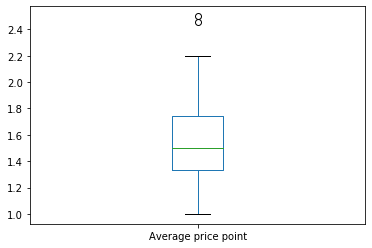

In [602]:
#Average price point visualized
df_proportion['Average price point'].plot.box()

Next, the average rating of the French restaurants is calculated using the premium call "venue details" of the Foursquare API. Please note that, to conserve the number of premium calls, the retrieval limit has been intentionally lowered to 5. Admittedly, the accuracy of the data will naturally tend to increase with the increasing number of retrieval limit, and this should be the case if there is no limit to the number of calls.

In [603]:
categoryid = '4bf58dd8d48988d10c941735' #"French" category
search_radius = 1000 #Increased to encompass more restaurants
fs_result_list = []

for search_latitude,search_longitude in zip(df_proportion['Latitude'],df_proportion['Longitude']):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&time=any&day=any&openNow=0&sortByPopularity=1'.format(
                fs_client_id, 
                fs_client_secret, 
                fs_version, 
                search_latitude, 
                search_longitude, 
                search_radius, 
                fs_premium_limit,
                categoryid)

    fs_result = requests.get(url).json()['response']['groups'][0]['items']
    venue_id_list = [item['venue']['id'] for item in fs_result]

    rating_list = []
    for n in range(len(venue_id_list)):
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                venue_id_list[n],
                fs_client_id, 
                fs_client_secret, 
                fs_version)

        fs_result = requests.get(url).json()
        try:
            rating_list.append(float(fs_result['response']['venue']['rating']))
        except:
            pass
    
    fs_result_list.append([sum(rating_list),len(rating_list)])

In [604]:
#Create a list of average ratings of French restaurants
average_rating_list = []
for item in fs_result_list:
    if item[1] != 0:
        average_rating_list.append(item[0]/item[1])
    else:
        average_rating_list.append(0)

#Append the list to the dataframe
df_proportion['Average Rating, French'] = average_rating_list

<h3>3.3. K-means</h3><a id="5"></a>

Now that all required data have been collected using Foursquare API, the dataframe will now be processed to allow for clustering of the data points. The clustering method to be employed is K-means, to ensure that all the data points belong to one of the clusters.

In [618]:
#Remove the columns that are not necessary
df_main = df_proportion[['Latitude','Longitude','French #','Average price point','Average Rating, French']]

#Drop the rows that contain NaN
df_main = df_main.dropna(subset=['Average price point'],axis=0)

#Rename the columns with more intuitive names
df_main.columns = ['Latitude','Longitude','Number of French restaurants','Average price point of restaurants','Average rating of French restaurants']

#Review the resulting dataframe
df_main.head()

,Latitude,Longitude,Number of French restaurants,Average price point of restaurants,Average rating of French restaurants
0,22.285039,114.158382,50,1.904000,7.34
1,22.269917,114.150667,0,1.750000,0.00
2,22.286332,114.133626,8,1.706522,7.28
3,22.286870,114.150267,50,1.818182,7.34
4,22.276643,114.239773,0,1.285714,0.00


In [625]:
#The variables will be standardized to ensure no one variable exerts more influence over the result than others
from sklearn.preprocessing import StandardScaler

cluster_input = df_main.values[:,2:]
cluster_input_ss = StandardScaler().fit_transform(cluster_input)

#K-means model training (the number of clusters is chosen arbitrarily)
from sklearn.cluster import KMeans 

model_kmeans = KMeans(init="k-means++",n_clusters=5)
model_kmeans.fit(cluster_input_ss)

labels = model_kmeans.labels_

df_main['Cluster label'] = labels

In [655]:
df_main.head()

,Latitude,Longitude,Number of French restaurants,Average price point of restaurants,Average rating of French restaurants,Cluster label
0,22.285039,114.158382,50,1.904000,7.34,2
1,22.269917,114.150667,0,1.750000,0.00,4
2,22.286332,114.133626,8,1.706522,7.28,3
3,22.286870,114.150267,50,1.818182,7.34,2
4,22.276643,114.239773,0,1.285714,0.00,1


<h2>4. Results</h2><a id="6"></a>

In this section, the characteristics of each cluster resulted from k-means are examined by observing the values of the variables that were defined and collected in previous sections. The variables, to reiterate, include: (1) **the density of French restaurants** (indicating the degree of interest overlap from similar venues), (2) **the average price point of the restaurants** (showing how affluent the customers in the are are), and (3) **the average rating of French restaurants** (gauging the degree of the competition from similar venues).


The statistics of each variable (listed in the table below) is used as the basis of comparison from which the other results are interpreted.

In [640]:
df_main[['Number of French restaurants','Average price point of restaurants','Average rating of French restaurants']].describe()

,Number of French restaurants,Average price point of restaurants,Average rating of French restaurants
count,67.000000,67.000000,67.000000
mean,3.373134,1.542571,1.321642
std,10.052643,0.333009,2.731950
min,0.000000,1.000000,0.000000
25%,0.000000,1.333333,0.000000
50%,0.000000,1.500000,0.000000
75%,1.500000,1.741667,0.000000
max,50.000000,2.500000,7.700000


In [762]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

def df_dist_plot(cluster_number):

    fig = plt.figure(figsize=(15, 5)) # create figure

    ax_0 = fig.add_subplot(1, 3, 1)
    ax_1 = fig.add_subplot(1, 3, 2)
    ax_2 = fig.add_subplot(1, 3, 3)

    df_temp_overall = df_main[:]
    df_temp_cluster_specific = df_main[df_main['Cluster label']==cluster_number][:]

    df_temp_overall['Cluster label'] = 'Overall'
    df_temp_cluster_specific['Cluster label'] = f'Cluster {cluster_number}'

    df_temp = pd.concat([df_temp_overall,df_temp_cluster_specific])

    sns.distplot(df_temp[df_temp['Cluster label']=='Overall']['Number of French restaurants'],color='blue',label='Overall',kde=False,hist=True,norm_hist=True,ax=ax_0)
    sns.distplot(df_temp[df_temp['Cluster label']==f'Cluster {cluster_number}']['Number of French restaurants'],color='red',label=f'Cluster {cluster_number}',kde=False,hist=True,norm_hist=True,ax=ax_0)
    ax_0.set_ylim([0,1])
    ax_0.legend()

    sns.distplot(df_temp[df_temp['Cluster label']=='Overall']['Average price point of restaurants'],color='blue',label='Overall',kde=False,hist=True,norm_hist=True,ax=ax_1)
    sns.distplot(df_temp[df_temp['Cluster label']==f'Cluster {cluster_number}']['Average price point of restaurants'],color='red',label=f'Cluster {cluster_number}',kde=False,hist=True,norm_hist=True,ax=ax_1)
    ax_1.legend()

    sns.distplot(df_temp[df_temp['Cluster label']=='Overall']['Average rating of French restaurants'],color='blue',label='Overall',kde=False,hist=True,norm_hist=True,ax=ax_2)
    sns.distplot(df_temp[df_temp['Cluster label']==f'Cluster {cluster_number}']['Average rating of French restaurants'],color='red',label=f'Cluster {cluster_number}',kde=False,hist=True,norm_hist=True,ax=ax_2)
    ax_2.legend()
    
    plt.show()

In [803]:
def folium_of_cluster(cluster_number): 
    map_hk_temp = []
    map_hk_temp = folium.Map(location=[22.3193,114.1694],zoom_start=8,tiles='OpenStreetMap')

    for latitude,longitude in zip(df_temp[df_temp['Cluster label']==f'Cluster {cluster_number}']['Latitude'],df_temp[df_temp['Cluster label']==f'Cluster {cluster_number}']['Longitude']):
        folium.CircleMarker(
            [float(latitude),float(longitude)],
            radius=7,
            color='teal',
            fill=True,
            fill_opacity=0.5,
            parse_html=False).add_to(map_hk_temp)
        
    map_hk_temp

<h3>4.1. Cluster 0: The Fringe</h3><a id="7"></a>

The plots show that, in comparison to the overall trends in Hong Kong, the regions in this cluster have few to zero French restaurants (negligible because the average rating is all 0) and the nearby restaurants tend to have lower price points. This means that the neighbors in this cluster will not be compatible with the high-price business model of the client, and thus these regions will not be considered further.

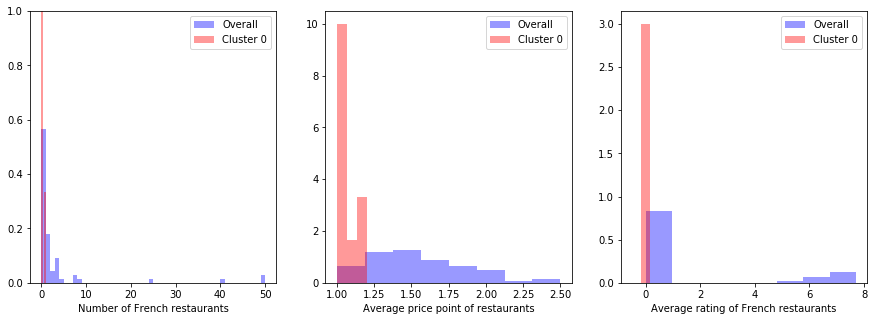

In [761]:
df_dist_plot(0)

The map supports that these regions are in the preserved natural parts of the region.

In [829]:
map_hk_cluster0 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_main[df_main['Cluster label']==0]['Latitude'],df_main[df_main['Cluster label']==0]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_cluster0)

map_hk_cluster0

<h3>4.2. Cluster 1: Dizygotic Twin of Cluster 0</h3><a id="8"></a>

The characteristics are highly similar to cluster 0 except that the price points are higher. Also will not be considered further.

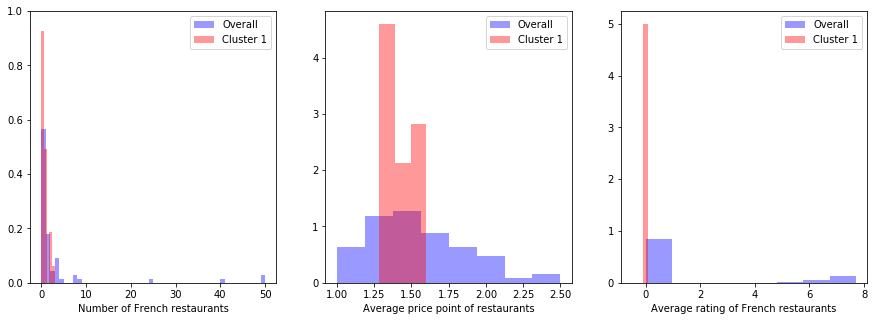

In [795]:
df_dist_plot(1)

In [827]:
map_hk_cluster1 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_main[df_main['Cluster label']==1]['Latitude'],df_main[df_main['Cluster label']==1]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_cluster1)

map_hk_cluster1

<h3>4.3. Cluster 2: Little Paris</h3><a id="9"></a>

This cluster is marked by the highest number of French restaurants, most of which very high ratings. In addition, the average price point of the restaurants are also higher than the other two clustered previous considered. The map reveals that this cluster consists of locations that are considered the busiest in Hong Kong, such as Sheung Wan, Wan Chai, etc.

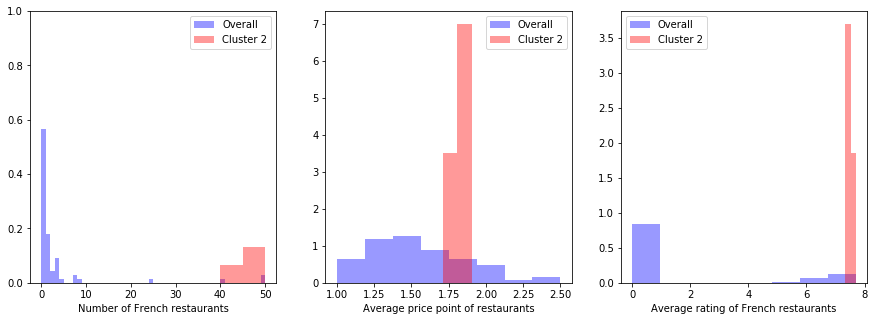

In [798]:
df_dist_plot(2)

In [830]:
map_hk_cluster2 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_main[df_main['Cluster label']==2]['Latitude'],df_main[df_main['Cluster label']==2]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_cluster2)

map_hk_cluster2

<h3>4.4. Cluster 3: Middle of the Litter</h3><a id="10"></a>

This cluster has zero to some French restaurants with the average rating more diversified than cluster 2. The competition from other French venues imposed on the stakeholders will be less than cluster 2, thanks to the the varied distribution of the measured characteristics.

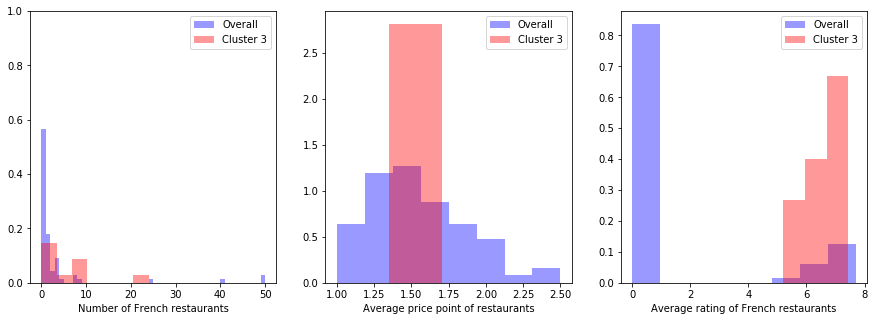

In [834]:
df_dist_plot(3)

In [832]:
map_hk_cluster3 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_main[df_main['Cluster label']==3]['Latitude'],df_main[df_main['Cluster label']==3]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_cluster3)

map_hk_cluster3

<h3>4.5. Cluster 4: Opulent Dens</h3><a id="11"></a>

The last cluster, unlike the others, are marked with few to zero French restaurants with the higher percentile of the price point of the nearby restaurants. The pre-established French restaurants have zero ratings.

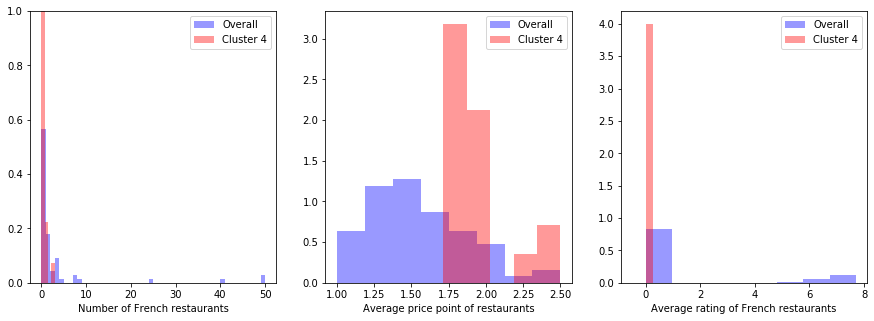

In [835]:
df_dist_plot(4)

In [836]:
map_hk_cluster4 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_main[df_main['Cluster label']==4]['Latitude'],df_main[df_main['Cluster label']==4]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_cluster4)

map_hk_cluster4

<h2>5. Discussion and Conclusion</h2><a id="12"></a>

Before interpreting the results, the expectations of the stakeholders will be recapped first. The French restaurant business run by the stakeholders offers expensive menus and target customers who are willing to experience the best of the Michellin-starred gastronomic experiences without worrying about price tags. In other words, the stakeholders would prefer to open their first branch **in an area where there are enough people who can afford the menus.** Hong Kong, however, already has other businesses that already offer similar experiences, firmly rooted in business-heavy areas marked by cluster 4. The stakeholders, knowing that their self-interest would be compromised by other existing French restaurant businesses, said they want to **start their branch somewhere that would pose little to no competition**.


With the above bolded statements in mind, it seems that the cluster that best fits the expectations of the stakeholders is the cluster 4. This cluster will be further dissected to narrow the number of candidate locations to a handful. The below dataframe of the cluster 4 entries shows that two of the variables (number of French restaurants and the average rating of French restaurants) do not vary enough to influence the decision making process. Therefore, the average price point is the only one of the selected variables that can and should affect where the stakeholders want to open their branch. This said, the stakeholders were recommended to visit the places in the order listed in the dataframe, from top to bottom.

In [851]:
df_excerpt = df_main[df_main['Cluster label']==4].sort_values(by='Average price point of restaurants',ascending=False,axis=0)
df_excerpt.reset_index(inplace=True)
df_excerpt.drop(['index'],axis=1,inplace=True)

df_excerpt.head(10)

,Latitude,Longitude,Number of French restaurants,Average price point of restaurants,Average rating of French restaurants,Cluster label
0,22.462795,114.156274,1,2.500000,0.0,4
1,22.297658,114.237257,0,2.454545,0.0,4
2,22.357656,114.257546,1,2.200000,0.0,4
3,22.370099,114.024439,0,2.000000,0.0,4
4,22.321913,114.138317,0,2.000000,0.0,4
5,22.436037,114.190911,0,2.000000,0.0,4
6,22.423329,114.258505,0,2.000000,0.0,4
7,22.430670,114.257678,0,2.000000,0.0,4
8,22.410660,114.274122,0,2.000000,0.0,4
9,22.209614,114.029637,0,1.869565,0.0,4


Here are the coordinates of the **top 3 locations** recommended to the stakeholders.

In [853]:
map_hk_top3 = folium.Map(location=[22.38,114.1694],zoom_start=11,tiles='OpenStreetMap')

for latitude,longitude in zip(df_excerpt[:3]['Latitude'],df_excerpt[:3]['Longitude']):
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius=7,
        color='teal',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_hk_top3)

map_hk_top3